## Get all data

We start this analysis by importing data from ElasticSearch into a Python script. 

In [2]:
import numpy as np
import pandas
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# create a client instance of the library
elastic_client = Elasticsearch(timeout=60, max_retries=10, retry_on_timeout=True)
elastic_client.cluster.health(wait_for_status='yellow', request_timeout=55)

{'cluster_name': 'es-docker-cluster',
 'status': 'yellow',
 'timed_out': False,
 'number_of_nodes': 1,
 'number_of_data_nodes': 1,
 'active_primary_shards': 15,
 'active_shards': 15,
 'relocating_shards': 0,
 'initializing_shards': 0,
 'unassigned_shards': 2,
 'delayed_unassigned_shards': 0,
 'number_of_pending_tasks': 0,
 'number_of_in_flight_fetch': 0,
 'task_max_waiting_in_queue_millis': 0,
 'active_shards_percent_as_number': 88.23529411764706}

In [3]:
elastic_docs = []
s = Search(using=elastic_client, index="opensea")
s = s.source(excludes=[
    "last_sale_orginal", "image_original_url", "image_preview_url", "image_url", "os_id",
    'animation_url', '@scraped', 'animation_original_url', 
    'permalink', 'sell_order_usd', 'buy_order_usd'
])

i = 0
for hit in s.scan():
    i += 1
    if i <= 200000: # skip first 200k because of scraped data inconsistencies
        continue
    id = hit.meta.id
    obj = hit.to_dict()
    obj["id"] = id
    elastic_docs.append(obj)

print("documents returned:", len(elastic_docs))

documents returned: 1786870


In [4]:
# create a Pandas DataFrame array from the fields dict
elastic_df = pandas.DataFrame(elastic_docs)

print('elastic_df:', type(elastic_df))

elastic_df: <class 'pandas.core.frame.DataFrame'>


In [5]:
pandas.set_option('max_columns', None)

In [15]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786870 entries, 0 to 1786869
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   creator                  object 
 1   latest_sale_token_value  float64
 2   collection_created       object 
 3   latest_sale_usd          float64
 4   description              object 
 5   is_animation             bool   
 6   @latest_sale_timestamp   object 
 7   name                     object 
 8   collection_slug          object 
 9   collection_description   object 
 10  contract_scheme          object 
 11  latest_sale_token        object 
 12  id                       object 
 13  instagram                object 
 14  twitter                  object 
 15  img_path                 object 
 16  twitter_follower         float64
 17  preview_path             object 
dtypes: bool(1), float64(3), object(14)
memory usage: 233.5+ MB


In [7]:
del elastic_docs

## Drop columns
Some columns are not valuable for our analysis or may contain a large number of not available information. As a result, it was decided to delete them.
Not needed:
- token_id
- external_link

More then 90% NAs:
- telegram_follower
- telegram
- medium_follower
- medium

In [8]:
elastic_df.drop(['token_id', 'external_link'], inplace=True, axis=1)
elastic_df.drop(['telegram_follower', 'telegram', 'medium_follower', 'medium'], inplace=True, axis=1)

In [10]:
elastic_df.drop(['discord', 'instagram_follower', 'wikipedia'], inplace=True, axis=1)

In [14]:
elastic_df.drop(['discord-follower'], inplace=True, axis=1)

In [16]:
#elastic_df.drop(['price_crypto'], inplace=True, axis=1)

In [62]:
elastic_df.head()

,creator,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,...,twitter_follower,preview_path,sale_time,collection_created_year,word_count_coll_desc,unique_asset,instagram_account,twitter_account,z_twitter_follower,z_sale_usd
0,0xb40197806a07b3b2dbb4b43d255ef32c328d44ab,126.311360,A Rug Radio Membership Pass is step one in get...,False,Rug Radio Membership Pass,rug-radio-membership-pass,"[rug, radio, first, fully, decentralize, mediu...",ERC721,ETH,q-sh530Bt_K6OZC-bA85,...,0.0,NaN,11,2021,27,0,0,0,-0.082795,-0.147300
1,WoofpackNFT,76.970985,"WoofPack is a generative NFT collection of , e...",False,Woofpack #1398,woofpacknft,"[freedom, woofpack, adorable, algorithmically,...",ERC721,ETH,e-sh530Bt_K6OZC-XA9q,...,12770.0,C:\nft_data\preview\e-sh530Bt_K6OZC-XA9q_noext...,11,2021,81,0,1,1,-0.039362,-0.151532
2,PudgyPenguinsKing,71.050140,"Lil Pudgys are a collection of , randomly gene...",False,Lil Pudgy #2168,lilpudgys,"[lil, pudgys, collection, randomly, generate, ...",ERC721,ETH,eesh530Bt_K6OZC-XA9U,...,47722.0,C:\nft_data\preview\eesh530Bt_K6OZC-XA9U_noext...,11,2021,24,0,0,1,0.079516,-0.152040
3,0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8,193.414270,"raisingcapital. eth, an ENS name.",False,raisingcapital.eth,ens,"[ethereum, name, service, en, domain, secure, ...",ERC721,ETH,fush530Bt_K6OZC-Xw8O,...,137809.0,NaN,11,2019,36,0,0,1,0.385920,-0.141545
4,CryptoRastas_Team,78.944600,Cryptorasta Shannon Stone is a doctor from New...,False,Cryptorasta #04798,cryptorastas-collection,"[nft, collection, reggae, culture, info, crypt...",ERC721,ETH,hush530Bt_K6OZC-Xw_b,...,5648.0,C:\nft_data\preview\hush530Bt_K6OZC-Xw_b_noext...,11,2021,10,0,1,1,-0.063585,-0.151363


Some rows didn't have the infomation about their price. The reson could be lay either on Opensea or creators or transfars without money invovment. Due to the small amount of such cases I decided to drop them too.

## Renaming

In [17]:
elastic_df = elastic_df.rename(columns={'latest_sale_token':'sale_token'})
elastic_df = elastic_df.rename(columns={'latest_sale_token_value':'price_crypto'})
elastic_df = elastic_df.rename(columns={'latest_sale_usd':'sale_usd'})
elastic_df = elastic_df.rename(columns={'collection_slug':'collection_name'})

In [18]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1786870 entries, 0 to 1786869
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   creator                 object 
 1   price_crypto            float64
 2   collection_created      object 
 3   sale_usd                float64
 4   description             object 
 5   is_animation            bool   
 6   @latest_sale_timestamp  object 
 7   name                    object 
 8   collection_name         object 
 9   collection_description  object 
 10  contract_scheme         object 
 11  sale_token              object 
 12  id                      object 
 13  instagram               object 
 14  twitter                 object 
 15  img_path                object 
 16  twitter_follower        float64
 17  preview_path            object 
dtypes: bool(1), float64(3), object(14)
memory usage: 233.5+ MB


## Convert dates and remove missing values

In [19]:
from datetime import datetime

In [20]:
elastic_df = elastic_df[elastic_df['@latest_sale_timestamp'].isna() == False]
elastic_df['sale_time'] = elastic_df.apply(lambda row: datetime.fromisoformat(row['@latest_sale_timestamp']).time().hour, axis=1)
elastic_df.drop(['@latest_sale_timestamp'], inplace=True, axis=1)
elastic_df['collection_created_year'] = elastic_df.apply(lambda row: datetime.fromisoformat(row['collection_created']).year, axis=1)
elastic_df.drop(['collection_created'], inplace=True, axis=1)

## NAs

These columns are features that contain valuable information for the analysis, and with their help, our model could improve its performance. Empty rows in textual columns

In [21]:
elastic_df['collection_description'].fillna("", inplace = True)

In [22]:
def descriptionFill(row):
    if row['description'] == None:
        return row['collection_description']
    else:
        return row['description']

elastic_df['description'] = elastic_df.apply(lambda row : descriptionFill(row), axis = 1)

In [23]:
elastic_df['creator'].fillna("", inplace = True)
elastic_df['sale_token'].fillna("", inplace = True)
elastic_df['name'].fillna("", inplace = True)
elastic_df['instagram'].fillna("", inplace = True)
elastic_df['twitter_follower'] = elastic_df['twitter_follower'].fillna(0)
elastic_df['twitter'].fillna("", inplace = True)

Remove rows with NAs for cols we absolutely need in our analysis.

In [24]:
elastic_df = elastic_df[elastic_df['sale_usd'].isna() == False]

Here we need to be sure that all rows contain image data. We check if we have an image for every row.

In [25]:
from PIL import Image
import os

In [26]:
images_missing = 0

def get_image_path(row):
    global images_missing

    img_path = []
    preview = row['preview_path']
    if preview != None and pandas.isna(preview) == False and preview.startswith('/scraper/data/preview/'):
        img_path.append(os.path.join(os.sep, 'C:' + os.sep, 'nft_data', 'preview', preview[len('/scraper/data/preview/'):]))

    id = row['id']
    image_folder = '..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'
    img_path.append(image_folder + 'preview\\' + id + '_noext.png')
    img_path.append(image_folder + 'img\\' + id + '_noext.png')
    orginal = row['img_path']
    if orginal != None and pandas.isna(orginal) == False:
        img_path.append(orginal)
        if orginal.count('\\') > 0:
            img_path.append(image_folder + 'img\\' + orginal[orginal.rindex('\\') + 1:])

    final_path = None
    for path in img_path:
        if os.path.exists(path):
            final_path = path
            break
    if final_path == None:
        images_missing += 1
        return None

    return final_path

In [27]:
elastic_df['image_path'] = elastic_df.apply(get_image_path, axis=1)
elastic_df = elastic_df[elastic_df['image_path'].isna() == False]
print('removed because of images missing:', images_missing)

removed because of images missing: 591033


In [28]:
len_before = len(elastic_df)
elastic_df = elastic_df[elastic_df['contract_scheme'].isna() == False]
len_after = len(elastic_df)
print('removed because of missing contract scheme:', len_before - len_after)

removed because of missing contract scheme: 25648


In [29]:
elastic_df = elastic_df.reset_index(drop=True)

## Cleaning
We have some textual features that must be cleaned because these steps ensure that the text data is in a form that a computer can understand and work with. 

In [38]:
elastic_df['twitter'] = elastic_df['twitter'].apply(lambda url: url.replace('https://cdn.syndication.twimg.com/widgets/followbutton/info.json?screen_names=',''))

In [39]:
import re

In [40]:
#remove everything except characters and white spaces.
def clean_text(text):
    # matches: www.gg-io.lkl?q=tz#jjk + opensea.io/collection/ape123 + medium.com/cryptopoop + sub.domain.org
    clean_link = re.compile(r'(^|\s)(https?:\/\/)?(www\.)?[\w\-\.]+\.(com|io|eth|org|gg|de)(\/[\w\.\-\/#\?\=]*)?(\s|$)')
    clean_files = re.compile('[\w-]*\.(png|jpg|tif|obj|svg|gif|js|jpeg)')
    clean = re.compile('[^a-zA-Z \.,\?!:]+')
    clean_missingspace = re.compile('(\w)\.(\w)')
    clean_doublespace = re.compile('\s\s+')
    clean_puncts = re.compile('\.\.+')
    clean_text = re.sub(clean_link, ' ', text)
    clean_text = re.sub(clean_files, '', clean_text)
    clean_text = re.sub(clean, ' ', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_puncts, '.', clean_text)
    clean_text = re.sub(clean_missingspace, '\\1. \\2', clean_text)
    clean_text = re.sub(clean_doublespace, ' ', clean_text)

    return clean_text

In [33]:
elastic_df['collection_description'] = elastic_df['collection_description'].apply(lambda text: clean_text(text))
elastic_df['description'] = elastic_df['description'].apply(lambda text: clean_text(text))

In [34]:
import nltk
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bb1\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [35]:
from time import time

In [36]:
from lemmatization import lemma_text
from multiprocessing import cpu_count, Pool

Due to the amount of data we have, the lemmatization may be very time-consuming, and it would be great if we could process this in parallel. That is why we run multiple processors at one time.

In [37]:
if __name__ ==  '__main__': 
    t = time()
    pool = Pool(cpu_count() - 4)
    elastic_df['collection_description'] = pool.map(lemma_text, elastic_df['collection_description'])
    print(elastic_df['collection_description'].head(5))
    print('Time: {} mins'.format(round((time() - t) / 60, 2)))

0    [freedom, woofpack, adorable, algorithmically,...
1    [lil, pudgys, collection, randomly, generate, ...
2    [ethereum, name, service, en, domain, secure, ...
3    [nft, collection, reggae, culture, info, crypt...
4    [croakz, collection, small, amphibious, creatu...
Name: collection_description, dtype: object
Time: 10.84 mins


## Feature creation
Feature engineering is an essential step in the process of data preparation. Firstly it may give us new valuible insights about the data we are working with. Second, it may improve data performance and be a key to successfully using Machine Learning algorithms.
We start by counting the number of words each creator uses in the description of the collection. 

In [41]:
elastic_df['word_count_coll_desc'] = elastic_df["collection_description"].apply(lambda x: len(str(x).split(" ")))

The next we identify if an asset is unique or not. As a rule unique asset has a unique name without numbers or collection's name

In [42]:
#unique name = 1/yes
#not unique name = 0/no
def unique_name(row):
    if row['name'] == None or row['name'] == "": #all missing values are 0, because these names aren't unique
        return 0
    search_number = re.search('#[0-9]', row['name']) #all names with #1234 are also not unique
    if search_number != None:
        return 0
    search_number = re.search('^[0-9]+$', row['name']) #all names with 1234 are also not unique
    if search_number != None:
        return 0
    #comparison of the name of an asset & collection's name. First we need to prepare the text 
    lowercase = row['name'].lower()
    minus = re.compile('[^a-zA-Z]|official')
    minus_case = re.sub(minus, '', lowercase)
    if row['collection_name'] != None:
        slug = row['collection_name'].lower()
        slug_clean = re.sub(minus, '', lowercase)
        if len(slug_clean) > 0 and slug_clean == minus_case:
            return 0
    print(row['collection_name'], row['name'], minus_case)    
    return 1 

elastic_df['unique_asset'] = elastic_df.apply(lambda row : unique_name(row), axis = 1)

n-e-o-n-v-i-b-e ネオン 377 
yat 💎🆚🦍 
kimo-animals キショ鳥 
yat 💯🙌💯 
n-e-o-n-v-i-b-e ネオン 55 
ghost-kidz 11:11  
cryptovoxels 31 이문로 
saintj10 區塊鏈 
decentraland 😎 
n-e-o-n-v-i-b-e ネオン 183 
n-e-o-n-v-i-b-e ネオン 16 
typical-tigers # 27 
salviadroid 💤 
ptcolorgraphs  🏛️ 
ptcolorgraphs 🌿🥊 
n-e-o-n-v-i-b-e ネオン 176 
n-e-o-n-v-i-b-e ネオン 292 
n-e-o-n-v-i-b-e ネオン 3 
n-e-o-n-v-i-b-e ネオン 56 
n-e-o-n-v-i-b-e ネオン 447 
n-e-o-n-v-i-b-e ネオン 480 
talesofnexus-monster 1/100 
sleepy-sloth-society-by-zzz-labs #??? 
inbetweeners #🧸 
forenft 姜昱同-《坚守愉悦》 
winterspb 59.938714, 30.326104-59.937849, 30.325717 
n-e-o-n-v-i-b-e ネオン 168 
winterspb 59.944870, 30.312220-59.938069, 30.300980 
winterspb 59.949322, 30.326378-59.944527, 30.322255 
winterspb 59.950283, 30.326188-59.948506, 30.327689 
winterspb 59.936135, 30.326872-59.935408, 30.326164 
n-e-o-n-v-i-b-e ネオン 161 
winterspb 59.944151, 30.328336-59.939307, 30.317388 
winterspb 59.929344, 30.204952-59.923840, 30.215960 
ptcolorgraphs 🦚🏷️ 
cryptokitties 3.5/5 
inbetweene

animo-official 35.42.87.70.83.55.44.90.59 
animo-official 21.56.44.59.87.23.70.42.92 
animo-official 00.77.97.37.00.88.05.70.67 
animo-official 32.06.61.36.78.66.40.56.30 
animo-official 18.88.43.36.97.74.74.10.35 
animo-official 66.76.45.76.65.30.09.95.01 
animo-official 90.36.06.02.03.66.63.28.70 
animo-official 63.28.75.44.06.55.12.78.34 
animo-official 00.08.64.09.13.10.66.60.84 
animo-official 30.49.48.00.52.00.16.35.82 
animo-official 14.46.00.23.05.11.62.54.83 
animo-official 07.68.34.84.67.32.24.49.03 
animo-official 84.56.29.48.32.18.88.36.95 
animo-official 93.60.49.96.89.88.95.84.62 
animo-official 38.39.27.10.25.10.10.36.99 
animo-official 36.12.09.31.08.04.02.40.71 
animo-official 21.00.48.05.65.88.62.24.72 
animo-official 36.00.93.20.88.50.06.64.44 
animo-official 14.00.09.44.55.88.77.78.29 
animo-official 15.56.31.42.92.36.39.70.18 
animo-official 66.54.05.91.60.11.95.14.99 
animo-official 36.80.28.66.86.00.17.91.10 
animo-official 35.36.06.97.49.34.66.22.75 
animo-offic

animo-official 70.66.98.02.08.44.50.28.71 
animo-official 50.00.89.28.09.00.24.25.03 
animo-official 06.35.50.78.27.22.63.54.80 
animo-official 77.00.92.59.55.22.22.07.47 
animo-official 25.50.34.81.86.70.69.66.50 
animo-official 35.51.32.09.23.39.33.70.57 
animo-official 00.70.81.12.08.17.54.84.33 
animo-official 49.54.38.60.30.34.10.20.20 
animo-official 60.10.01.53.00.32.44.00.70 
animo-official 42.00.59.79.55.33.11.28.63 
animo-official 54.50.15.43.31.77.51.49.55 
animo-official 48.09.31.40.52.33.16.30.01 
animo-official 91.80.33.56.48.63.32.76.79 
animo-official 07.33.69.30.04.33.40.84.95 
animo-official 54.00.21.66.33.77.76.28.48 
animo-official 90.65.03.33.04.66.21.85.79 
animo-official 78.87.11.31.72.68.06.28.23 
animo-official 28.42.89.06.80.66.11.90.39 
animo-official 77.71.10.23.81.64.11.77.06 
animo-official 00.72.54.28.66.77.60.90.70 
animo-official 00.72.93.73.90.20.00.28.34 
animo-official 28.36.90.46.95.66.42.56.12 
animo-official 56.60.70.78.43.88.33.35.16 
animo-offic

animo-official 30.57.15.90.67.05.33.18.17 
animo-official 75.03.93.60.00.91.11.48.03 
animo-official 12.95.11.30.51.64.54.84.66 
animo-official 84.00.50.99.73.06.02.54.10 
animo-official 77.30.33.58.38.66.90.14.82 
animo-official 24.51.42.89.43.22.75.91.92 
animo-official 54.14.81.32.65.00.33.07.98 
animo-official 90.25.88.90.09.55.24.84.69 
shaolinsamurai 🥷 
animo-official 12.90.96.57.90.22.07.84.87 
animo-official 91.63.32.20.62.88.88.49.68 
animo-official 84.20.77.30.92.84.66.84.35 
animo-official 91.72.41.82.57.90.72.00.17 
animo-official 75.65.26.24.39.10.22.00.37 
animo-official 78.65.02.78.72.35.84.35.06 
animo-official 56.00.48.81.00.11.44.91.51 
animo-official 63.63.71.80.72.16.73.76.23 
typical-tigers # 659 
animo-official 15.15.04.74.77.30.77.21.87 
animo-official 90.90.87.28.32.77.56.35.18 
animo-official 06.72.84.07.56.12.90.00.73 
the-50s # 15 
animo-official 36.00.17.70.15.55.00.84.53 
animo-official 84.00.47.20.98.55.24.24.05 
animo-official 36.00.06.75.75.77.78.35.19 


n-e-o-n-v-i-b-e ネオン 44 
animo-official 28.00.85.43.59.16.45.72.84 
tasai แมวส้ม 
n-e-o-n-v-i-b-e ネオン 343 
animo-official 48.81.02.85.50.92.11.42.48 
animo-official 66.00.22.02.53.80.00.75.65 
animo-official 12.91.16.27.17.36.00.35.06 
tasai กระบือ 
animo-official 91.65.51.36.75.44.10.90.18 
n-e-o-n-v-i-b-e ネオン 57 
animo-official 28.18.56.89.92.55.77.49.13 
animo-official 55.08.36.50.34.88.54.84.39 
animo-official 42.48.56.64.21.72.44.77.23 
animo-official 70.72.58.71.23.77.04.84.68 
animo-official 84.06.27.88.18.66.09.14.78 
animo-official 14.80.80.09.36.11.77.90.11 
animo-official 21.02.34.92.83.63.36.06.08 
animo-official 14.00.93.07.50.25.77.49.14 
animo-official 42.07.05.81.57.90.98.56.65 
animo-official 40.08.52.91.88.30.50.42.01 
animo-official 21.88.39.36.14.55.40.56.42 
animo-official 78.54.67.31.28.77.68.07.58 
animo-official 91.40.50.25.51.22.88.14.91 
n-e-o-n-v-i-b-e ネオン 121 
animo-official 07.00.49.77.95.55.84.84.52 
animo-official 07.72.28.92.10.18.44.20.06 
animo-official

animo-official 00.58.91.87.49.55.20.84.30 
animo-official 56.00.97.29.19.55.00.48.08 
animo-official 07.34.91.30.69.48.11.28.80 
animo-official 33.88.52.16.38.22.88.92.18 
animo-official 54.15.18.71.16.33.90.30.77 
animo-official 14.39.30.60.60.44.88.30.80 
animo-official 91.15.38.81.57.77.55.36.82 
animo-official 54.48.35.05.04.11.91.42.42 
animo-official 42.00.06.50.01.55.88.28.59 
animo-official 72.54.39.39.45.88.78.24.25 
animo-official 42.90.22.06.61.10.44.78.61 
animo-official 84.21.50.03.73.66.88.70.11 
animo-official 77.60.22.95.95.60.25.06.40 
animo-official 36.00.19.66.38.88.78.00.49 
animo-official 18.75.71.62.71.77.03.00.58 
animo-official 63.39.39.98.95.66.22.70.22 
animo-official 00.30.07.04.57.80.20.00.57 
animo-official 42.45.52.30.26.50.55.87.37 
animo-official 00.63.89.86.80.98.11.15.62 
animo-official 90.42.89.24.02.11.68.06.40 
animo-official 68.66.10.17.21.44.93.63.14 
animo-official 45.48.46.09.45.66.70.07.63 
animo-official 77.00.97.76.51.77.88.77.62 
animo-offic

animo-official 78.32.72.74.22.88.81.72.19 
animo-official 70.36.96.24.22.10.77.77.64 
animo-official 49.66.65.59.23.66.55.25.07 
animo-official 84.84.28.68.29.33.68.56.93 
animo-official 07.10.93.68.75.55.88.75.75 
animo-official 14.54.00.52.26.55.00.84.43 
animo-official 72.00.47.43.30.00.08.84.71 
animo-official 35.09.37.69.54.44.66.28.69 
animo-official 21.51.03.13.18.00.66.49.95 
animo-official 54.00.84.25.19.00.54.56.53 
animo-official 07.68.29.29.90.40.44.72.60 
animo-official 24.65.78.88.20.48.36.32.64 
animo-official 12.70.87.63.89.66.25.54.76 
animo-official 49.27.87.08.15.55.72.66.46 
animo-official 15.28.85.28.25.30.11.12.82 
animo-official 91.24.93.71.35.52.22.91.15 
animo-official 36.56.24.92.73.92.68.78.71 
animo-official 63.92.48.67.48.44.78.28.77 
animo-official 56.80.98.33.17.88.78.70.36 
animo-official 49.18.86.82.99.77.22.70.69 
animo-official 42.75.01.85.55.88.66.63.83 
animo-official 70.65.43.65.35.42.36.72.91 
animo-official 18.52.69.34.39.24.28.28.82 
animo-offic

typical-tigers # 687 
animo-official 91.00.62.91.84.66.72.63.57 
shaolinsamurai 🥷 
animo-official 42.05.80.41.31.55.22.42.63 
animo-official 56.00.27.48.54.33.05.84.69 
animo-official 77.72.09.26.44.55.77.07.94 
animo-official 60.50.44.54.64.80.09.91.61 
animo-official 91.27.58.37.91.11.00.18.31 
animo-official 42.06.71.43.70.22.40.07.81 
animo-official 14.80.28.89.38.62.88.95.28 
animo-official 36.48.18.43.86.77.88.42.21 
animo-official 36.57.73.52.92.22.00.35.84 
animo-official 07.00.34.95.38.88.66.77.58 
animo-official 24.70.05.84.36.18.35.66.63 
animo-official 44.85.72.18.95.50.44.78.42 
animo-official 35.45.09.27.39.24.44.00.75 
animo-official 06.90.39.57.65.11.08.70.48 
animo-official 63.66.79.48.23.00.00.28.13 
animo-official 42.27.99.73.05.88.91.00.35 
animo-official 78.48.59.17.41.16.30.35.76 
6radients 12.100 
animo-official 77.46.77.27.01.55.44.40.43 
animo-official 90.72.64.71.06.55.56.15.99 
animo-official 76.12.04.20.73.18.44.49.49 
animo-official 49.60.32.23.73.00.66.48.

typical-tigers # 1621 
typical-tigers # 893 
typical-tigers # 1032 
social-bees-university # 9140 
typical-tigers # 1439 
typical-tigers # 592 
typical-tigers # 271 
typical-tigers # 365 
animo-official 60.56.74.20.18.24.33.90.50 
typical-tigers # 1939 
typical-tigers # 1210 
typical-tigers # 45 
typical-tigers # 2040 
typical-tigers # 204 
typical-tigers # 1818 
typical-tigers # 1370 
typical-tigers # 2769 
typical-tigers # 3215 
typical-tigers # 1525 
typical-tigers # 1231 
typical-tigers # 3218 
typical-tigers # 1104 
animo-official 84.72.93.62.58.55.40.68.63 
typical-tigers # 3835 
typical-tigers # 510 
typical-tigers # 3399 
typical-tigers # 3212 
typical-tigers # 3593 
animo-official 72.82.47.74.47.00.05.90.29 
typical-tigers # 332 
social-bees-university # 5158 
typical-tigers # 3211 
typical-tigers # 1236 
social-bees-university # 6378 
typical-tigers # 1442 
typical-tigers # 1441 
social-bees-university # 3852 
typical-tigers # 562 
animo-official 36.45.88.08.95.77.56.42.56 
d

typical-tigers # 3634 
typical-tigers # 3853 
social-bees-university # 4928 
lightbeingbyavasol روشنی 
typical-tigers # 932 
little-dixie № :: 81 
animo-official 00.88.09.55.94.55.06.30.51 
animo-official 15.54.40.05.28.00.88.66.84 
animo-official 77.40.94.77.52.15.03.84.08 
cryptovoxels 5 약령시로 
typical-tigers # 2716 
typical-tigers # 1568 
social-bees-university # 3042 
little-dixie № :: 140 
n-e-o-n-v-i-b-e ネオン 208 
social-bees-university # 6384 
n-e-o-n-v-i-b-e ネオン 536 
n-e-o-n-v-i-b-e ネオン 187 
reconramsnft ? 
brokenseadao ##### 
typical-tigers # 3003 
social-bees-university # 5260 
social-bees-university # 2986 
animo-official 48.30.95.81.91.33.64.21.32 
brokenseadao ##### 
reconramsnft ? 
social-bees-university # 2662 
social-bees-university # 2660 
brokenseadao ##### 
a-ton-of-coke 67/1000 
typical-tigers # 1901 
reconramsnft ? 
dojo-warriors ??? 
social-bees-university # 6716 
animo-official 78.00.05.35.47.27.66.54.33 
social-bees-university # 5480 
animo-official 21.12.42.17.66

typical-tigers # 2425 
animo-official 30.80.33.52.40.24.36.36.01 
typical-tigers # 3533 
typical-tigers # 3535 
typical-tigers # 3543 
typical-tigers # 2099 
typical-tigers # 3544 
typical-tigers # 1725 
typical-tigers # 3539 
typical-tigers # 3776 
typical-tigers # 3044 
typical-tigers # 2052 
animo-official 48.20.80.01.52.77.48.49.79 
the34project 01//34 
animo-official 70.23.60.20.60.20.44.21.40 
social-bees-university # 5786 
typical-tigers # 3534 
typical-tigers # 3537 
animo-official 21.24.06.11.26.44.33.36.68 
typical-tigers # 995 
duomaxwell-collection 兔兔 
the-365 365/001 
hamen 路吸派＃06- 哈們系列 
hamen 路吸派＃11 - 哈們系列 
hamen 路吸派＃10 - 哈們系列 
social-bees-university # 8268 
lightbeingbyavasol కాంతి 
hamen 路吸派＃65 - 哈們系列 
hamen 路吸派＃66 - 哈們系列 
hamen 路吸派＃39 - 哈們系列 
typical-tigers # 1820 
typical-tigers # 1686 
typical-tigers # 3531 
hamen 路吸派＃05 - 哈們系列 
hamen 路吸派＃07- 哈們系列 
hamen 路吸派＃44 - 哈們系列 
hamen 路吸派＃55 - 哈們系列 
hamen 路吸派＃62 - 哈們系列 
animo-official 21.20.05.77.54.22.00.04.19 
hamen 路吸派＃36 -

typical-tigers # 853 
typical-tigers # 2609 
social-bees-university # 6066 
typical-tigers # 1646 
typical-tigers # 3638 
social-bees-university # 8458 
typical-tigers # 2860 
typical-tigers # 1622 
animo-official 84.00.11.52.09.00.08.14.98 
social-bees-university # 5932 
animo-official 35.22.90.21.61.81.44.07.37 
typical-tigers # 1957 
social-bees-university # 9196 
animo-official 06.58.60.86.72.66.88.42.21 
animo-official 14.36.47.00.41.81.33.90.37 
social-bees-university # 8454 
social-bees-university # 4152 
animo-official 66.70.59.25.08.14.90.28.60 
animo-official 48.36.87.12.87.12.62.42.35 
social-bees-university # 5400 
typical-tigers # 3286 
typical-tigers # 2689 
typical-tigers # 2186 
typical-tigers # 615 
typical-tigers # 685 
typical-tigers # 2420 
typical-tigers # 1625 
typical-tigers # 1948 
typical-tigers # 2975 
typical-tigers # 1354 
typical-tigers # 2863 
typical-tigers # 2697 
typical-tigers # 1117 
typical-tigers # 844 
typical-tigers # 2976 
social-bees-university 

animo-official 35.22.72.92.53.72.68.56.71 
uiethma 07:51 
animo-official 60.00.99.72.64.00.84.08.34 
animo-official 28.05.97.51.03.72.22.00.46 
animo-official 63.84.02.87.43.60.33.48.55 
animo-official 84.80.26.43.15.11.00.35.97 
animo-official 12.00.18.75.80.72.90.48.02 
animo-official 84.72.23.11.04.88.93.60.76 
animo-official 63.00.82.98.42.55.22.91.13 
yat 👁❤🔩 
gm-365 12-26-21 
shaolinsamurai 🥷 
nixtisine-generative-shapes 31/690 
nixtisine-generative-shapes 41/690 
nixtisine-generative-shapes 96/690 
yat 👁❤🚑 
yat 👁️❤️🏹 
animo-official 77.00.74.74.02.71.40.55.30 
nixtisine-generative-shapes 26/690 
animo-official 70.45.88.63.40.00.33.20.05 
animo-official 42.38.49.20.43.70.55.70.06 
animo-official 00.28.05.48.52.31.48.18.68 
animo-official 63.20.76.28.61.22.11.14.78 
animo-official 54.72.23.47.82.55.63.15.22 
animo-official 63.84.31.22.02.00.00.06.79 
animo-official 42.80.32.23.82.78.72.49.63 
animo-official 14.00.69.15.54.16.40.20.20 
animo-official 07.78.85.29.62.27.88.72.63 
ani

animo-official 48.40.88.77.47.48.64.15.76 
cryptovoxels 29 약령중앙로 
animo-official 42.45.85.69.83.11.09.84.18 
typical-tigers # 3321 
365dayskorea 7/25 
animo-official 70.24.91.08.76.24.33.84.87 
animo-official 80.65.60.91.99.00.70.84.27 
typical-tigers # 760 
typical-tigers # 3540 
animo-official 91.42.98.50.21.44.00.04.48 
social-bees-university # 8614 
social-bees-university # 5170 
social-bees-university # 7722 
social-bees-university # 8738 
sea-maidens 𝕿𝖍𝖊 𝕹𝖔𝖙𝖎𝖈𝖎𝖓𝖌 
social-bees-university # 5604 
social-bees-university # 5122 
the-365 365/003 
social-bees-university # 9064 
cryptoderby フージキセキ 
cryptoderby スタークリスタル 
cryptoderby グリグリクル 
social-bees-university # 7068 
typical-tigers # 2663 
untitled-collection-203806978 洋葱公主 
redlioneye-gazette 𝐑𝐄𝐃𝐋𝐈𝐎𝐍𝐄𝐘𝐄 𝐆𝐀𝐙𝐄𝐓𝐓𝐄 #𝟐𝟏 
typical-tigers # 1843 
typical-tigers # 1230 
social-bees-university # 8526 
animo-official 70.55.55.93.05.36.60.90.19 
untitled-collection-85730435 花葬 
social-bees-university # 7752 
typical-tigers # 1637 
social-bees-u

The last two features we engineer are whether either creator has an Instagram and Twitter account or not. 

In [43]:
# instagram account? yes - 1, no -0
def instAcc(row):
    insta = row['instagram']
    if isinstance(insta, str) and len(insta) > 0:
        return 1
    else:
        return 0
        
elastic_df['instagram_account'] = elastic_df.apply(lambda row : instAcc(row), axis = 1)

In [44]:
#account? yes - 1, no -0
def twitterAcc(row):
    twitt = row['twitter']
    if isinstance(twitt, str) and len(twitt) > 0:
        return 1
    else:
        return 0
        
elastic_df['twitter_account'] = elastic_df.apply(lambda row : twitterAcc(row), axis = 1)

## Categories

In [45]:
elastic_df['contract_scheme'] = elastic_df['contract_scheme'].astype('category')
elastic_df['name'] = elastic_df['name'].astype('category')
elastic_df['creator'] = elastic_df['creator'].astype('category')
elastic_df['instagram'] = elastic_df['instagram'].astype('category')
elastic_df['twitter'] = elastic_df['twitter'].astype('category')

In [46]:
elastic_df['is_animation'] = elastic_df['is_animation'].astype('category')
elastic_df['collection_name'] = elastic_df['collection_name'].astype('category')
elastic_df['sale_token'] = elastic_df['sale_token'].astype('category')
elastic_df['collection_created_year'] = elastic_df['collection_created_year'].astype('category')
elastic_df['unique_asset'] = elastic_df['unique_asset'].astype('category')
elastic_df['instagram_account'] = elastic_df['instagram_account'].astype('category')
elastic_df['twitter_account'] = elastic_df['twitter_account'].astype('category')

## Saving the data 

In [67]:
import pickle

pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'

def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_pkl(elastic_df, 'df_before_norm.pkl')

## z-score for outlier
We use z-score to identify outliers. Z-scores are the number of standard deviations above and below the mean that each value slips. Then we cut the values that are under and above the threshold. 

In [47]:
from scipy import stats

In [66]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150715 entries, 0 to 1150714
Data columns (total 27 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   creator                  1150715 non-null  category
 1   price_crypto             1150205 non-null  float64 
 2   sale_usd                 1150715 non-null  float64 
 3   description              1150715 non-null  object  
 4   is_animation             1150715 non-null  category
 5   name                     1150715 non-null  category
 6   collection_name          1150715 non-null  category
 7   collection_description   1150715 non-null  object  
 8   contract_scheme          1150715 non-null  category
 9   sale_token               1150715 non-null  category
 10  id                       1150715 non-null  object  
 11  instagram                1150715 non-null  category
 12  twitter                  1150715 non-null  category
 13  img_path                 11

twitter_follower

In [54]:
elastic_df['z_twitter_follower'] = stats.zscore(elastic_df['twitter_follower'])

In [55]:
threshold = 3
len_before = len(elastic_df)
elastic_df = elastic_df[elastic_df['z_twitter_follower'].abs() <= threshold]
len_after = len(elastic_df)
print(len_before - len_after)

2477


sale_usd

In [56]:
elastic_df['z_sale_usd'] = stats.zscore(elastic_df['sale_usd'])

len_before = len(elastic_df)
elastic_df = elastic_df[elastic_df['z_sale_usd'].abs() <= threshold]
len_after = len(elastic_df)
print(len_before - len_after)

5776


In [57]:
elastic_df = elastic_df.reset_index(drop=True)

## y-binning
Due to the specificity of the master thesis for the analysis of whether NFT may help artists combat their precarity working and living conditions, it was decided to shift from regression into classification problems, and this is the problem of assigning a category to each item. Based on the binns, we may better analyse the potential of NFT for artists in the discussion section of the master thesis. 

In [58]:
max_usd = np.max(elastic_df['sale_usd']) + 1 # added 1 because sometimes the max value was not bined
print(f'Max price: {max_usd}')

Max price: 43913.4


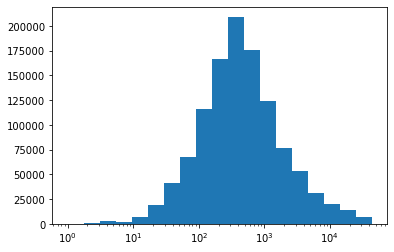

In [59]:
plt.hist(elastic_df['sale_usd'], bins = np.logspace(start = np.log10(1), stop = np.log10(max_usd), num = 20))
plt.gca().set_xscale("log")
plt.show()

In [60]:
bins = np.logspace(start = np.log10(1), stop = np.log10(max_usd), num = 20)
bins

array([1.00000000e+00, 1.75528327e+00, 3.08101936e+00, 5.40806175e+00,
       9.49268032e+00, 1.66623430e+01, 2.92471319e+01, 5.13370013e+01,
       9.01109796e+01, 1.58170295e+02, 2.77633673e+02, 4.87325742e+02,
       8.55394723e+02, 1.50146005e+03, 2.63548770e+03, 4.62602748e+03,
       8.11998865e+03, 1.42528802e+04, 2.50178423e+04, 4.39134000e+04])

In [61]:
def bin_number(price):
    for i in range(0, len(bins)):
        start = 0 - 0.01
        if i > 0:
            start = bins[i-1]
        end = bins[i]
        if price > start and price <= end:
            return int(i) 
        
elastic_df['bin_log_usd'] = elastic_df['sale_usd'].apply(bin_number)

In [62]:
bin_labels = []
for i in range(0, len(bins)):
    start = 0
    if i > 0:
        start = bins[i-1]
    end = bins[i]
    s = '{:.1f}'.format(start)
    e = '{:.1f}'.format(end)
    bin_labels.append(f'{s}-{e}')
bin_labels

['0.0-1.0',
 '1.0-1.8',
 '1.8-3.1',
 '3.1-5.4',
 '5.4-9.5',
 '9.5-16.7',
 '16.7-29.2',
 '29.2-51.3',
 '51.3-90.1',
 '90.1-158.2',
 '158.2-277.6',
 '277.6-487.3',
 '487.3-855.4',
 '855.4-1501.5',
 '1501.5-2635.5',
 '2635.5-4626.0',
 '4626.0-8120.0',
 '8120.0-14252.9',
 '14252.9-25017.8',
 '25017.8-43913.4']

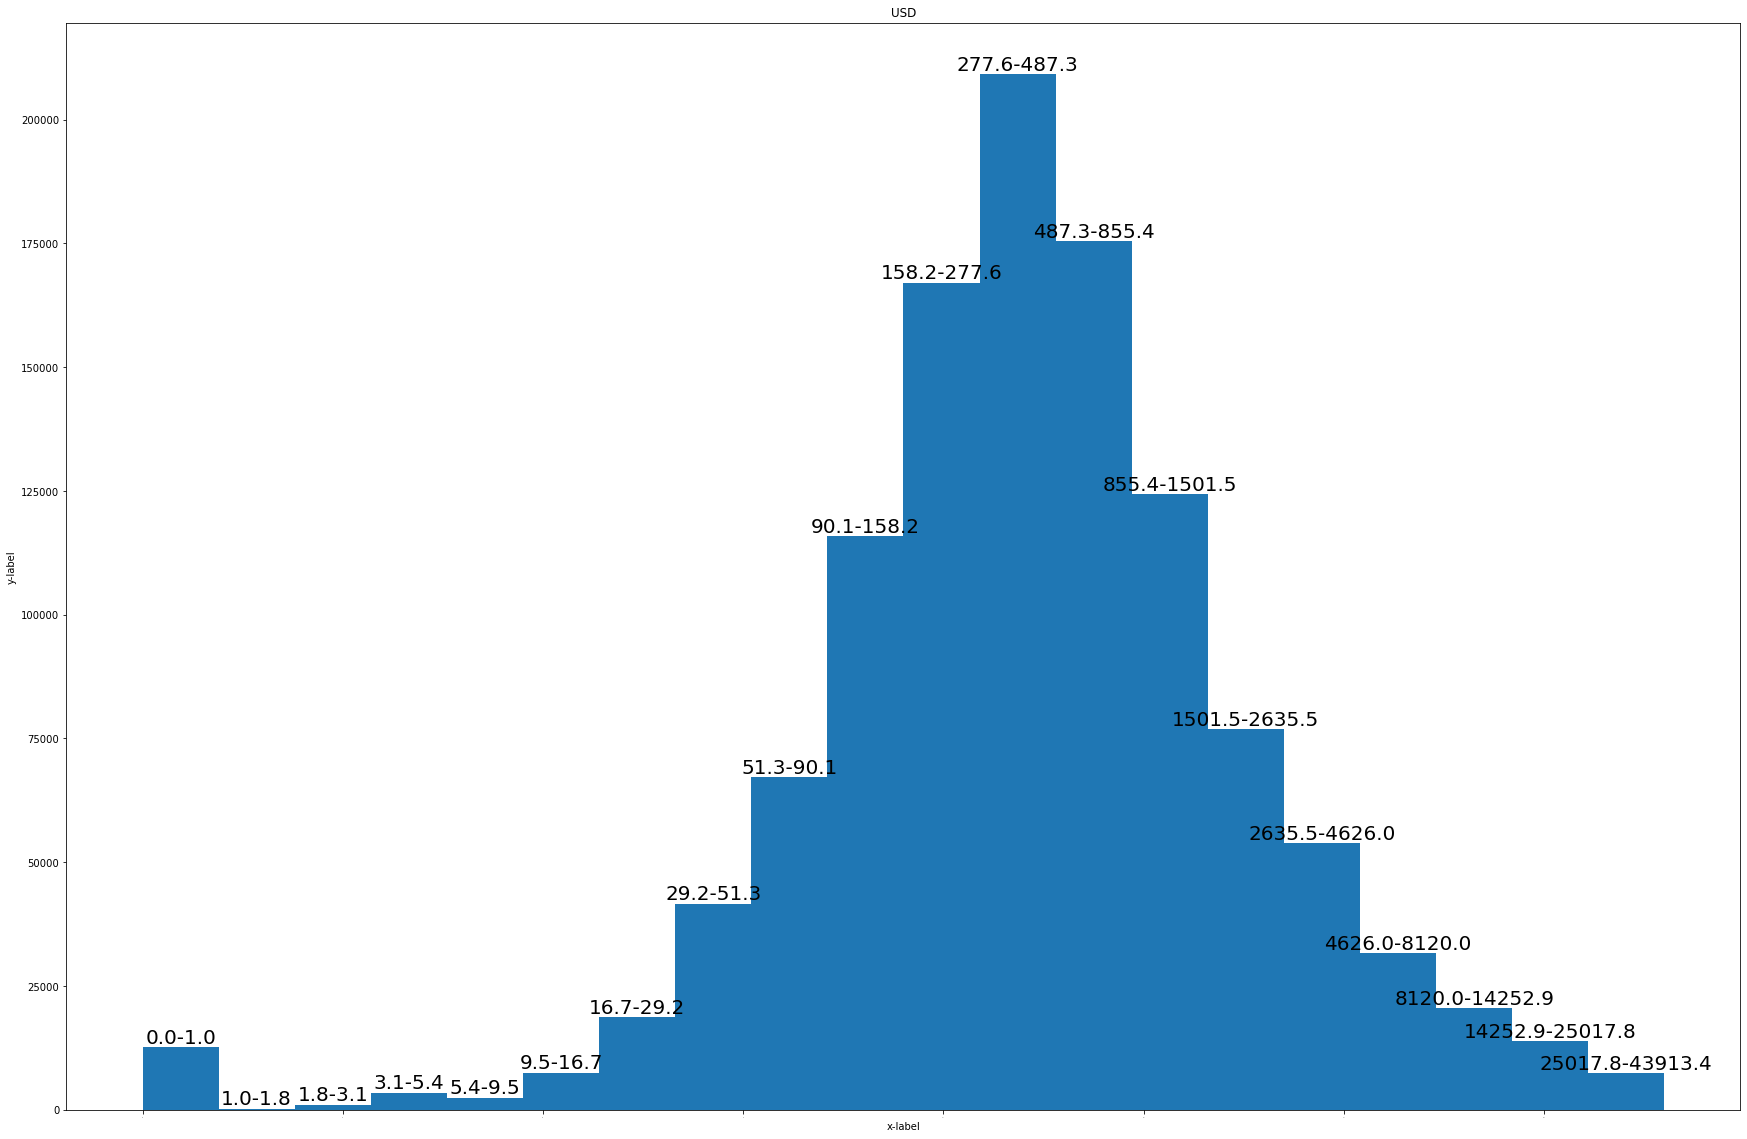

In [63]:
# Creating histogram
fig, ax = plt.subplots(1, 1, figsize=(30,20))
ax.hist(elastic_df['bin_log_usd'], bins=len(bin_labels), align='mid')
# Set title
ax.set_title("USD")
# adding labels
ax.set_xlabel('x-label')
ax.set_ylabel('y-label')
# Make some labels.

#range(len(bin_labels)
rects = ax.patches
for rect, label in zip(rects, bin_labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom', fontsize=20)
plt.xticks(fontsize=0)
# Show plot
plt.show()

In [64]:
elastic_df['cat_usd'] = elastic_df['bin_log_usd'].astype('category')

In [65]:
idx_to_class = {
    idx: class_
    for idx, class_ in enumerate(bin_labels)
}
class_to_idx = {bin_labels[i]: i for i in range(len(bin_labels))}

class_to_idx

{'0.0-1.0': 0,
 '1.0-1.8': 1,
 '1.8-3.1': 2,
 '3.1-5.4': 3,
 '5.4-9.5': 4,
 '9.5-16.7': 5,
 '16.7-29.2': 6,
 '29.2-51.3': 7,
 '51.3-90.1': 8,
 '90.1-158.2': 9,
 '158.2-277.6': 10,
 '277.6-487.3': 11,
 '487.3-855.4': 12,
 '855.4-1501.5': 13,
 '1501.5-2635.5': 14,
 '2635.5-4626.0': 15,
 '4626.0-8120.0': 16,
 '8120.0-14252.9': 17,
 '14252.9-25017.8': 18,
 '25017.8-43913.4': 19}

## Cat and num prep

In [74]:
elastic_df.columns.tolist()

['creator',
 'sale_usd',
 'description',
 'is_animation',
 'name',
 'collection_name',
 'collection_description',
 'contract_scheme',
 'sale_token',
 'id',
 'instagram',
 'twitter',
 'img_path',
 'twitter_follower',
 'preview_path',
 'sale_time',
 'collection_created_year',
 'word_count_coll_desc',
 'unique_asset',
 'instagram_account',
 'twitter_account',
 'z_twitter_follower',
 'z_sale_usd',
 'bin_log_usd',
 'cat_usd']

In [68]:
cat_col = [
    'creator',
    'is_animation',
    'name',
    'collection_name',
    'contract_scheme',
    'sale_token',
    'instagram',
    'twitter',
    'collection_created_year',
    'unique_asset',
    'instagram_account',
    'twitter_account'
]

num_col = [
    'sale_usd',
    'twitter_follower',
    'sale_time',
    'word_count_coll_desc',
    'z_twitter_follower',
    'z_sale_usd',
    
]

In [69]:
from sklearn.preprocessing import MinMaxScaler

Differences in the scales across input variables may negatively influence the modelling process. For example, large input values can result in large weight values. In the end model's performance will be poor. That is why here, we scale numeric data. 

In [70]:
scaler = MinMaxScaler()

In [71]:
scaled = scaler.fit_transform(elastic_df[num_col])
for i, col in enumerate(elastic_df[num_col].columns):
    newCol = []
    for ii in range(0, len(scaled)):
        newCol.append(scaled[ii][i])
    elastic_df[col] = newCol
elastic_df

,creator,price_crypto,sale_usd,description,is_animation,name,collection_name,collection_description,contract_scheme,sale_token,id,instagram,twitter,img_path,twitter_follower,preview_path,sale_time,collection_created_year,image_path,word_count_coll_desc,unique_asset,instagram_account,twitter_account,z_sale_usd,z_twitter_follower,bin_log_usd,cat_usd
0,WoofpackNFT,0.0195,0.001753,"WoofPack is a generative NFT collection of , e...",False,Woofpack #1398,woofpacknft,"[freedom, woofpack, adorable, algorithmically,...",ERC721,ETH,e-sh530Bt_K6OZC-XA9q,freedomwoofpack,freedomwoofpack,C:\nft_data\img\e-sh530Bt_K6OZC-XA9q_noext.png,0.014697,C:\nft_data\preview\e-sh530Bt_K6OZC-XA9q_noext...,0.478261,2021,..\..\opensea_scapper\opensea_nft_scrapper\dat...,0.279720,0,1,1,0.001753,0.014697,8,8
1,PudgyPenguinsKing,0.0180,0.001618,"Lil Pudgys are a collection of , randomly gene...",False,Lil Pudgy #2168,lilpudgys,"[lil, pudgys, collection, randomly, generate, ...",ERC721,ETH,eesh530Bt_K6OZC-XA9U,,pudgy_penguins,C:\nft_data\img\eesh530Bt_K6OZC-XA9U_noext.png,0.054924,C:\nft_data\preview\eesh530Bt_K6OZC-XA9U_noext...,0.478261,2021,..\..\opensea_scapper\opensea_nft_scrapper\dat...,0.080420,0,0,1,0.001618,0.054924,8,8
2,0x4fe4e666be5752f1fdd210f4ab5de2cc26e3e0e8,0.0490,0.004405,"raisingcapital. eth, an ENS name.",False,raisingcapital.eth,ens,"[ethereum, name, service, en, domain, secure, ...",ERC721,ETH,fush530Bt_K6OZC-Xw8O,,ensdomains,C:\nft_data\img\fush530Bt_K6OZC-Xw8O.svg,0.158605,NaN,0.478261,2019,..\..\opensea_scapper\opensea_nft_scrapper\dat...,0.122378,0,0,1,0.004405,0.158605,10,10
3,CryptoRastas_Team,0.0200,0.001798,Cryptorasta Shannon Stone is a doctor from New...,False,Cryptorasta #04798,cryptorastas-collection,"[nft, collection, reggae, culture, info, crypt...",ERC721,ETH,hush530Bt_K6OZC-Xw_b,cryptorastas,cryptorastas,C:\nft_data\img\hush530Bt_K6OZC-Xw_b_noext.png,0.006500,C:\nft_data\preview\hush530Bt_K6OZC-Xw_b_noext...,0.478261,2021,..\..\opensea_scapper\opensea_nft_scrapper\dat...,0.031469,0,1,1,0.001798,0.006500,8,8
4,0x92bce497efe4332a8f611004f67e14093b5d0e8c,0.0540,0.004854,"A collection of , unique CROAKZ that vibe in t...",False,CROAKZ 4323,croakz-v2-1,"[croakz, collection, small, amphibious, creatu...",ERC721,ETH,j-sh530Bt_K6OZC-ZA99,croakz_,CROAKZ_,C:\nft_data\img\j-sh530Bt_K6OZC-ZA99_noext.png,0.020263,C:\nft_data\preview\j-sh530Bt_K6OZC-ZA99_noext...,0.478261,2021,..\..\opensea_scapper\opensea_nft_scrapper\dat...,0.073427,0,1,1,0.004854,0.020263,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150710,Ape1683,0.0200,0.001150,"Bones Bananas is a collection of , unique, pro...",False,,bones-and-bananas,"[bone, banana, collection, unique, programmati...",ERC721,ETH,bR-ar34B-_EH3z1syssv,,bonesandbananas,/scraper/data/img/bR-ar34B-_EH3z1syssv_noext.png,0.004821,/scraper/data/preview/bR-ar34B-_EH3z1syssv_noe...,0.434783,2021,C:\nft_data\preview\bR-ar34B-_EH3z1syssv_noext...,0.108392,0,0,1,0.001150,0.004821,7,7
1150711,PrivateJetPyjamaParty,2.4900,0.143115,Private Jet Pyjama Party,False,#3208,pjpp,"[first, pjpp, collection, create, together, ar...",ERC721,ETH,aR-ar34B-_EH3z1syssP,pjpp.nft/,pjpp_nft,/scraper/data/img/aR-ar34B-_EH3z1syssP_noext.png,0.003264,/scraper/data/preview/aR-ar34B-_EH3z1syssP_noe...,0.434783,2021,C:\nft_data\preview\aR-ar34B-_EH3z1syssP_noext...,0.146853,0,1,1,0.143115,0.003264,16,16
1150712,0xd3f27738a6ca4ad6201ee934e5fcf3756a46aedb,0.1200,0.006897,"Persona Lamps is a collection of , LAMP NFTs w...",False,Persona Lamp #611,persona-lamps,"[persona, lamp, collection, lamp, nfts, variat...",ERC721,ETH,ax-ar34B-_EH3z1syssg,,persona_lamps,/scraper/data/img/ax-ar34B-_EH3z1syssg_noext.png,0.001146,/scraper/data/preview/ax-ar34B-_EH3z1syssg_noe...,0.434783,2021,C:\nft_data\preview\ax-ar34B-_EH3z1syssg_noext...,0.136364,0,0,1,0.006897,0.001146,11,11
1150713,0x07a5dc49c58a4418feb52426601abe556ca55cbe,0.0250,0.001437,Repeat Offenders is a collection of

## Truncat to top-cat only
Due to the memory's capacity, we limit ourselves to only top categories or categories with too many unique values. We may allow us to leave 4096 top categories.

In [72]:
def top_cat_values(cat, number):
    #tops = cat.value_counts()[:number].index.tolist()
    tops = cat.value_counts()[:number - 1].index.tolist()
    default_cat = number - 1
    #[f(x) if condition else g(x) for x in sequence]
    arr = [tops.index(x) if x in tops else default_cat for x in cat]
    return pandas.Series(arr).astype('category')

In [73]:
top_cat_limit = 4096
for col in cat_col:
    if top_cat_limit < len(elastic_df[col].cat.categories):
        elastic_df[col] = top_cat_values(elastic_df[col], top_cat_limit)

In [76]:
elastic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150715 entries, 0 to 1150714
Data columns (total 27 columns):
 #   Column                   Non-Null Count    Dtype   
---  ------                   --------------    -----   
 0   creator                  1150715 non-null  category
 1   price_crypto             1150205 non-null  float64 
 2   sale_usd                 1150715 non-null  float64 
 3   description              1150715 non-null  object  
 4   is_animation             1150715 non-null  category
 5   name                     1150715 non-null  category
 6   collection_name          1150715 non-null  category
 7   collection_description   1150715 non-null  object  
 8   contract_scheme          1150715 non-null  category
 9   sale_token               1150715 non-null  category
 10  id                       1150715 non-null  object  
 11  instagram                1150715 non-null  category
 12  twitter                  1150715 non-null  category
 13  img_path                 11

In [77]:
import pickle

pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'

def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

save_pkl(elastic_df, 'df_before_norm_tensor.pkl')

## Tensor

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
categorical_column_sizes = [len(elastic_df[column].cat.categories) for column in cat_col]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4096, 50), (2, 1), (4096, 50), (4096, 50), (3, 2), (30, 15), (4096, 50), (4096, 50), (4, 2), (2, 1), (2, 1), (2, 1)]


## Split the data
Here we transorm the data into tensors, split it into train, validation, and test set and save it as a pickle. 

In [141]:
from sklearn.model_selection import train_test_split

In [144]:
Y = elastic_df.pop('cat_usd')
X = elastic_df

In [145]:
train_size = 0.5

x_train, x_rem, y_train, y_rem = train_test_split(X, Y, train_size = train_size, random_state=69)

# Now since we want the valid and test size to be equal (20% each of overall data). 
# we have to define valid_size = 0.5 (that is 50% of remaining data)
x_valid, x_test, y_valid, y_test = train_test_split(x_rem, y_rem, test_size = 0.5, random_state=42)

print(x_train.shape), print(y_train.shape)
print(x_valid.shape), print(y_valid.shape)
print(x_test.shape), print(y_test.shape)

(574398, 25)
(574398,)
(287199, 25)
(287199,)
(287199, 25)
(287199,)


(None, None)

In [151]:
del x_rem, y_rem, elastic_df, X, Y

In [1]:
import pickle

In [3]:
pickle_dir = 'D:\\Code\\datascience\\MA_NFT\\data\\pickle\\'

In [32]:
def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#save_pkl(x_train, 'x_train')
#save_pkl(x_test, 'x_test')
#save_pkl(x_valid, 'x_valid')
save_pkl(y_train, 'y_train')
save_pkl(y_test, 'y_test')
save_pkl(y_valid, 'y_valid')

In [4]:
def load_pickle(name):
    with open(pickle_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)

#x_train = load_pickle('x_train')
#x_test = load_pickle('x_test')
x_valid = load_pickle('x_valid')
#y_train = load_pickle('y_train')
#y_test = load_pickle('y_test')
#y_valid = load_pickle('y_valid')

In [11]:
categorical_column_sizes = [len(x_valid[column].cat.categories) for column in cat_col]
categorical_embedding_sizes = [(col_size, min(50, (col_size+1)//2)) for col_size in categorical_column_sizes]
print(categorical_embedding_sizes)

[(4096, 50), (2, 1), (4096, 50), (4096, 50), (3, 2), (30, 15), (4096, 50), (4096, 50), (4, 2), (2, 1), (2, 1), (2, 1)]


In [13]:
def save_pkl(obj, name):
    with open(pickle_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
save_pkl(categorical_embedding_sizes, 'categorical_embedding_sizes')

In [ ]:
def output_prep(dataframe_y):
    dataframe_y = torch.tensor(dataframe_y).flatten()
    return dataframe_y    

In [4]:
torch.tensor([[1,2,3,4,666]]).flatten()

tensor([  1,   2,   3,   4, 666])

In [31]:
cat = x_valid.iloc[0]['contract_scheme']
cat

'ERC721'

In [32]:
x_valid['contract_scheme'].cat.categories.tolist().index(cat)

2

In [42]:
np.stack([[1,2,3,4,666], [1,2,3,4,666]], 1)

array([[  1,   1],
       [  2,   2],
       [  3,   3],
       [  4,   4],
       [666, 666]])

In [43]:
x_valid['contract_scheme'].cat.codes.values

array([2, 2, 2, ..., 2, 2, 2], dtype=int8)

In [6]:
y_valid = load_pickle('y_valid')

In [26]:
y_train = y_train.fillna(0)

In [28]:
y_train.isna().value_counts()

False    574398
Name: cat_usd, dtype: int64

In [31]:
y_test = y_test.fillna(0)
y_valid = y_valid.fillna(0)

In [1]:
from PIL import Image
from io import BytesIO 
import cairosvg

In [2]:
def get_preview_image(path):
    out = BytesIO()
    cairosvg.svg2png(url=path, write_to=out)
    return Image.open(out).convert('RGB')


In [ ]:
out = BytesIO()
cairosvg.svg2png(url='..\..\opensea_scapper\opensea_nft_scrapper\data\img\WtPC630B7RQ_xL7fyyQV.svg', write_to=out)
Image.open(out).convert('RGB') # x_train['image_path'].iloc[2292]

In [8]:
x_valid['image_path']

453052     C:\nft_data\preview\SGxfR34BklRAyF0RUsg3_noext...
1063738    C:\nft_data\preview\O5g8on4B94eJxbCKghzo_noext...
1061359    C:\nft_data\preview\HpbNoH4B94eJxbCK25tA_noext...
1074393    C:\nft_data\preview\_Jl2o34B94eJxbCKs3hD_noext...
310077     ..\..\opensea_scapper\opensea_nft_scrapper\dat...
                                 ...                        
357787     C:\nft_data\preview\oJgZKH4B_KkDEn3bFJ_i_noext...
79813      ..\..\opensea_scapper\opensea_nft_scrapper\dat...
1044516    C:\nft_data\preview\_kQEc34BsmfSdFj-9ixX_noext...
30472      ..\..\opensea_scapper\opensea_nft_scrapper\dat...
896055     C:\nft_data\preview\q5Rhnn4B94eJxbCKgwvw_noext...
Name: image_path, Length: 287199, dtype: object

In [9]:
path = x_valid['image_path'].iloc[4]
svg = path.endswith('.svg')
if path.startswith('..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'):
    path = path[len('..\\..\\opensea_scapper\\opensea_nft_scrapper\\data\\'):]
    path = 'E:\\data\\opensea\\' + path

path

'E:\\data\\opensea\\img\\B-P3AH4Br5kyUoyL9HLP_noext.png'